# Imports

In [1]:
from scvi.external import CPA
from scvi.external.cpa import register_dataset
from scvi.data import setup_anndata
from scvi.distributions import NegativeBinomial

import torch
import numpy as np
import pandas as pd
import anndata as ad
import plotnine as p9
import scanpy as sc
import matplotlib.pyplot as plt
import os

# Loading dataset

In [2]:
filepath = "/data/yosef2/users/pierreboyeau/CPA/datasets/GSM_new.h5ad"

In [3]:
dataset = sc.read_h5ad(filepath)

In [4]:
keys = {
    'perturbation_key': 'condition',
    'dose_key': 'dose_val',
    'cell_type_key': 'cell_type',
    'split_key': 'split',
     "treatments_key": "treatments"
} 


In [5]:
conditions = dataset.obs[keys["perturbation_key"]]
dosages = dataset.obs[keys["dose_key"]].values.astype(float)
codes = conditions.cat.codes.values

n_drugs = conditions.unique().shape[0]
n_cells = conditions.shape[0]
drugs_obsm = np.zeros((n_cells, n_drugs))
drugs_obsm[np.arange(n_cells), codes] = dosages

In [6]:
dataset.obsm[keys["treatments_key"]] = drugs_obsm

In [7]:
model_name = '/data/yosef2/users/pierreboyeau/CPA/pretrained_models/GSM/sweep_GSM_new_logsigm_model_seed=60_epoch=1120.pt'
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))

args["dataset_path"] = os.path.join("/data/yosef2/users/pierreboyeau/CPA", 'datasets/GSM_new.h5ad')

from compert.data import load_dataset_splits

datasets = load_dataset_splits(
    args["dataset_path"],
    args["perturbation_key"],
    args["dose_key"],
    args["cell_type_key"],
    args["split_key"]
)

In [8]:
datasets

{'training': <compert.data.SubDataset at 0x7fcdd23d4f40>,
 'training_control': <compert.data.SubDataset at 0x7fcdd23d4e20>,
 'training_treated': <compert.data.SubDataset at 0x7fcdd23d4670>,
 'test': <compert.data.SubDataset at 0x7fcdd131f8b0>,
 'test_control': <compert.data.SubDataset at 0x7fcdd07ee220>,
 'test_treated': <compert.data.SubDataset at 0x7fcdd07ee370>,
 'ood': <compert.data.SubDataset at 0x7fcdd07ee1c0>}

In [9]:
datasets['training_treated']

In [10]:
genes_control = datasets['training_control'].genes
# df_train = compert_api.evaluate_r2(datasets['training_treated'], genes_control)
# df_train['benchmark'] = 'CPA'


In [11]:
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np


def evaluate_r2(
    args,
    model,
    dataset,
    genes_control
):
    scores = pd.DataFrame(columns=[args["cell_type_key"],
                                    args["perturbation_key"],
                                    args["dose_key"],
                                    'R2_mean', 'R2_mean_DE', 'R2_var',
                                    'R2_var_DE', 'num_cells'])

    num, dim = genes_control.size(0), genes_control.size(1)

    total_cells = len(dataset)
    icond = 0
    for pert_category in np.unique(dataset.pert_categories):
        # pert_category category contains: 'celltype_perturbation_dose' info
        de_idx = np.where(
            dataset.var_names.isin(
                np.array(dataset.de_genes[pert_category]
                        )))[0]

        idx = np.where(dataset.pert_categories == pert_category)[0]
        if len(idx) > 0:
            emb_drugs = dataset.drugs[idx][0].view(
                1, -1).repeat(num, 1).clone()
            emb_cts = dataset.cell_types[idx][0].view(
                1, -1).repeat(num, 1).clone()
            return (emb_drugs, emb_cts)
            genes_predict = model.predict(
                genes_control, emb_drugs, emb_cts).detach().cpu()

            mean_predict = genes_predict[:, :dim]
            var_predict = genes_predict[:, dim:]

            # estimate metrics only for reasonably-sized drug/cell-type combos
            y_true = dataset.genes[idx, :].numpy()

            # true means and variances
            yt_m = y_true.mean(axis=0)
            yt_v = y_true.var(axis=0)
            # predicted means and variances
            yp_m = mean_predict.mean(0)
            yp_v = var_predict.mean(0)

            mean_score = r2_score(yt_m, yp_m)
            var_score = r2_score(yt_v, yp_v)

            mean_score_de = r2_score(yt_m[de_idx], yp_m[de_idx])
            var_score_de = r2_score(yt_v[de_idx], yp_v[de_idx])
            scores.loc[icond] = pert_category.split('_') +\
                [mean_score, mean_score_de, var_score, var_score_de, len(idx)]
            icond += 1

In [12]:
returns = evaluate_r2(
    args, model, dataset=datasets['training_treated'], genes_control=genes_control,
)

NameError: name 'model' is not defined

In [ ]:
returns[0].shape

In [ ]:
returns[1].shape

In [ ]:
genes_control.shape

In [ ]:
# genes_control = datasets['test_control'].genes
# df_ood = compert_api.evaluate_r2(datasets['ood'], genes_control)
# df_ood['benchmark'] = 'CPA'


In [ ]:
# genes_control = datasets['test_control'].genes
# df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
# df_test['benchmark'] = 'CPA'


In [ ]:
# df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
# df_test['benchmark'] = 'CPA'

In [ ]:
# df_ood['split'] = 'ood'
# df_test['split'] ='test'
# df_train['split'] ='train'

In [ ]:
# df_score = pd.concat([df_test, df_ood])
# df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)

In [ ]:
# cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'split', 'num_cells']
# df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE', 'R2_var'], ascending=False)
# df_latex = df_score[cols_print].copy()
# df_latex = df_latex.replace('ood', '\textbf{ood}')
# print(df_latex.to_latex(index=False, bold_rows=True, escape=False))

# Model

In [ ]:
dataset.obs.split

In [ ]:
setup_anndata(dataset)
batch_keys_to_dim = register_dataset(
    dataset,
    treatments_key=keys["treatments_key"],
    cat_keys=[keys["cell_type_key"]],
)

In [ ]:
module_kwargs = {
  'autoencoder_depth': 4,
  'autoencoder_width': 512,
}

plan_kwargs = {
    'adversary_depth': 2,
    'adversary_width': 64,
    'lr': 0.0011941101979918824,
    'penalty_adversary': 1.7904070562183636,
    'reg_adversary': 99.42740742104243,
    'adversary_lr': 0.0003097497089682243,
    'adversary_wd': 1.7743997657773115e-05,
    'autoencoder_wd': 8.75775474155043e-08,
    'adversary_steps': 4,
    'step_size_lr': 15,
}

trainer_kwargs = {
    'max_epochs': 2000,
    'early_stopping_patience': 20,
    'batch_size': 128,
}

In [ ]:
dataset.X.max()

In [ ]:
model = CPA(
    adata=dataset,
    batch_keys_to_dim=batch_keys_to_dim,
    split_key="split",
    **module_kwargs,
)
model.train(
    early_stopping_monitor="reconstruction_loss_validation",
    plan_kwargs=plan_kwargs,
    **trainer_kwargs,
)

In [ ]:
# return self.dosers(drugs) @ self.drug_embeddings.weight

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
model.history["adv_loss_train"].plot(ax=axes[0])
model.history["adv_penalty_train"].plot(ax=axes[1])
model.history["reconstruction_loss_train"].plot(ax=axes[2])

In [31]:
dataset.obs["split"]

index
A01_A01_RT_390     test
A01_A01_RT_396      ood
A01_A01_RT_400    train
A01_A01_RT_401    train
A01_A01_RT_402     test
                  ...  
H12_B02_RT_745    train
H12_B02_RT_750      ood
H12_B02_RT_752    train
H12_B02_RT_753     test
H12_B02_RT_761     test
Name: split, Length: 14811, dtype: category
Categories (3, object): ['ood', 'test', 'train']

# Analysis

### Drug embeddings

In [32]:
embeds = model.get_embeddings()

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import KernelPCA
import seaborn as sns


def fast_dimred(emb, method='KernelPCA'):
    """
    Takes high dimensional embeddings and produces a 2-dimensional representation
    for plotting.
    emb: np.array
        Embeddings matrix.
    method: str (default: 'KernelPCA')
        Method for dimensionality reduction: KernelPCA, UMAPpre, UMAPcos, tSNE.
        If None return first 2 dimensions of the embedding vector.
    """
    if method is None:
        return emb[:, :2]
    elif method == 'KernelPCA':
        similarity_matrix = cosine_similarity(emb)
        np.fill_diagonal(similarity_matrix, 1.0)
        X = KernelPCA(n_components=2, kernel="precomputed")\
            .fit_transform(similarity_matrix)
    else:
        raise NotImplementedError

    return X

In [34]:
def plot_similarity(
        emb,
        labels=None,
        col_dict=None,
        fig_width=4,
        fig_height=4,
        cmap='coolwarm',
        fmt='png',
        fontsize=7,
        file_format=None,
        file_name=None
    ):

    # first we take construct similarity matrix
    # add another similarity
    similarity_matrix = cosine_similarity(emb)

    df = pd.DataFrame(
        similarity_matrix,
        columns=labels,
        index=labels,
    )

    if col_dict is None:
        col_dict = get_colors(labels)

    network_colors = pd.Series(df.columns, index=df.columns).map(col_dict)

    sns_plot = sns.clustermap(
        df,
        cmap=cmap,
        center=0,
        row_colors=network_colors,
        col_colors=network_colors,
        mask=False,
        metric='euclidean',
        figsize=(fig_height, fig_width),
        vmin=-1, vmax=1,
        fmt=file_format
    )

    sns_plot.ax_heatmap.xaxis.set_tick_params(labelsize=fontsize)
    sns_plot.ax_heatmap.yaxis.set_tick_params(labelsize=fontsize)
    sns_plot.ax_heatmap.axis('equal')
    sns_plot.cax.yaxis.set_tick_params(labelsize=fontsize)
    
def get_colors(
    labels,
    palette=None,
    palette_name=None
    ):
    n_colors = len(labels)
    if palette is None:
        palette = get_palette(n_colors, palette_name)
    col_dict = dict(zip(labels, palette[:n_colors]))
    return col_dict

def get_palette(
        n_colors,
        palette_name='Set1'
    ):

    try:
        palette = sns.color_palette(palette_name)
    except:
        print('Palette not found. Using default palette tab10')
        palette = sns.color_palette()
    while len(palette) < n_colors:
        palette += palette

    return palette

In [35]:
embeds_pca = fast_dimred(embeds)

In [36]:
conditions.cat.categories.values

array(['BMS', 'Dex', 'Nutlin', 'SAHA', 'Vehicle'], dtype=object)

### Latent dose response

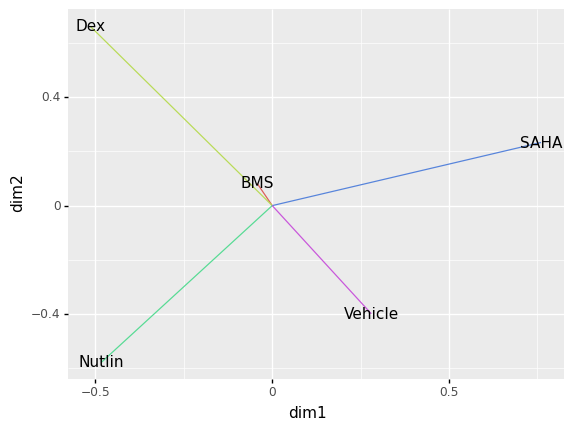

<ggplot: (8786280933238)>

In [37]:
plot_df = (
    pd.DataFrame(embeds_pca, columns=["dim1", "dim2"])
    .assign(
        treatments=conditions.cat.categories.values
    )
)

fig = (
    p9.ggplot(plot_df, p9.aes(xend="dim1", yend="dim2", color="treatments"))
#     + p9.geom_point()
    + p9.geom_segment(x=0.0, y=0.0)
#     + p9.geom_segment(x=0.0, y=0.0)
    + p9.geom_text(p9.aes(x="dim1", y="dim2", label="treatments"), inherit_aes=False)
    + p9.theme(legend_position="none")
)
fig

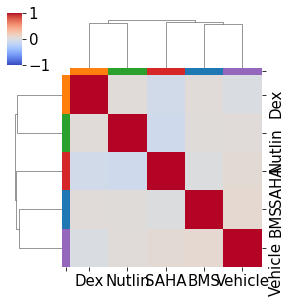

In [38]:
plot_similarity(
    embeds,
    labels=conditions.cat.categories.values,
    fontsize=15,
#     file_name=file_name_similarity
)

In [28]:
emd_unst

NameError: name 'emd_unst' is not defined

### Basic predictions

In [66]:
counterfactual_adata = dataset[dataset.obs.split == "train"].copy()

counterfactual_treatments = np.zeros_like(counterfactual_adata.obsm["treatments"])
counterfactual_treatments[:, 0] = 1.

counterfactual_cts = np.zeros_like(counterfactual_adata.obs.cell_type_scvi)

counterfactual_adata.obs.cell_type_scvi = counterfactual_cts
counterfactual_adata.obsm["treatments"] = counterfactual_treatments

In [67]:
model.predict(counterfactual_adata)

/data/yosef2/users/pierreboyeau/scvi-tools/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.


AttributeError: 'AnnData' object has no attribute 'ndim'